In [1]:
import pandas as pd 
import numpy as np
import rasterio
from rasterio.plot import show
import rioxarray
import pickle
import geopandas as gpd 
import folium
import matplotlib.pyplot as plt 
from tqdm import tqdm

In [2]:
import yaml
config_path = '/home/tu/tu_tu/tu_zxmav84/DS_Project/modules/config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
orthophoto_dir = config['data']['orthophotos']
grid_dir = config['data']['data'] + '/uhi_model/'

#### Read in Grid File

In [3]:
with open(grid_dir + 'final_200_a.pkl', 'rb') as f:
    grid = pickle.load(f)
grid = grid[['geometry', 'id']]
grid.head(2)

,geometry,id
0,"POLYGON ((11.54758 48.11423, 11.54758 48.11602...",1000001
1,"POLYGON ((11.54758 48.11782, 11.55027 48.11782...",1000002


### Read in Predictions

In [4]:
pred = pickle.load(open(grid_dir + '/raw/input.pkl', 'rb'))

pred = pred.set_crs('EPSG:25832')
pred.geometry = pred['geometry']
pred.head(3)

,label,geometry
0,low vegetation,"MULTIPOLYGON (((696500.000 5346500.000, 696500..."
0,road,"MULTIPOLYGON (((696661.621 5346500.000, 696661..."
0,impervious,"MULTIPOLYGON (((688320.312 5317462.402, 688320..."


In [5]:
# Reproject to EPSG:4326
gdf = pred.to_crs('EPSG:4326')

# Assign color coding to labels
cmap = {'ignore': "#000000", 'impervious': "#cccccc", 'building': '#ff00ff',
        'low vegetation':"#00ff00", 'water':'#0000ff', 'trees':"#008200", 'road':"#ff0000"}

# Create a new column for color
gdf['color'] = gdf['label'].map(cmap)

### Function to create .PNG file from grid elements

In [9]:
def create_mask_png(grid_elem):
    grid_geom = grid_elem.geometry

    # Subset and crop
    subset = gdf[gdf.geometry.intersects(grid_geom)].copy()
    subset['geometry'] = subset.geometry.intersection(grid_geom)

    # Create a new figure and axes with specific size (300x300 pixels)
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=75)

    # Plot the geometries with color based on label
    for color, data in subset.groupby('color'):
        data.plot(color=color, ax=ax)

    # Create a legend
    patches = [plt.plot([],[], marker="o", ms=10, ls="", color=color, 
                label="{:s}".format(label))[0]  for label, color in cmap.items()]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # axes off
    ax.set_xticks([])
    ax.set_yticks([])
    # Save the figure
    plt.savefig(f"{config['data']['segmentation_output']}/grids/{grid_elem.id}.png", bbox_inches='tight')

    plt.close()

 14%|█▍        | 94/667 [00:26<02:40,  3.56it/s]


KeyboardInterrupt: 

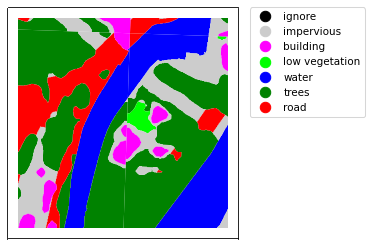

In [10]:
for i in tqdm(range(len(grid))):
    create_mask_png(grid.iloc[i,:])